In [72]:
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

sns.set_context("notebook")
# sns.set_style("darkgrid")
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [73]:
for path in glob.glob(
    "../fixedcells_3_cistopic_consensus/final_consensus_peaks/*.FIXEDCELLS__SCREEN_consensus_peaks.sorted.bed"
):
    newpath = path.replace(".sorted.bed", ".sorted.summits.bed")
    if not os.path.exists(newpath):

        df = pd.read_csv(path, sep="\t", header=None)
        df[1] = df[1].astype(int) + 250
        df[2] = df[2].astype(int) - 249
        df.to_csv(newpath, header=None, index=False, sep="\t")

In [74]:
for path in glob.glob(
    "../fixedcells_3_cistopic_consensus/downstream_analysis/DARs/*.FIXEDCELLS/*_DARs__unique.sorted.bed"
):
    newpath = path.replace(".sorted.bed", ".sorted.summits.bed")
    if not os.path.exists(newpath):
        df = pd.read_csv(path, sep="\t", header=None)
        df[1] = df[1].astype(int) + 250
        df[2] = df[2].astype(int) - 249
        df.to_csv(newpath, header=None, index=False, sep="\t")

# check peaks

In [75]:
bed_path_dict = {
    x.split("/")[-1].split("__")[0]: x
    for x in sorted(glob.glob("final_consensus_peaks/*summits.nearesttssdist.bed"))
}

In [76]:
col_names = [
    "chrom",
    "start",
    "end",
    "name",
    "score",
    "strand",
    "tss_chrom",
    "tss_start",
    "tss_end",
    "tss_name",
    "tss_score",
    "tss_strand",
    "tss_dist",
    "sample_id",
    "tech",
]


df_merged = pd.DataFrame()
if not os.path.exists("df_merged_peaks.tsv"):
    for sample, path in bed_path_dict.items():
        print(sample)

        df = pd.read_csv(
            path,
            sep="\t",
            header=None,
            names=col_names,
        )
        df["sample_id"] = sample
        df["tech"] = sample.split("_")[1]

        df_merged = pd.concat([df_merged, df])
        print(len(df))

    df_merged.columns = col_names
    df_merged.to_csv("df_merged_peaks.tsv", header=True, index=False, sep="\t")
else:
    df_merged = pd.read_csv("df_merged_peaks.tsv", header=0, sep="\t")
    df_merged.columns = col_names

tech_alias_dict = {
    "10xmultiome": "10x Multiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv2": "10x v2",
    "ddseq": "ddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "s3atac": "s3-ATAC",
}

tech_color_palette = {
    "10xv2": "#1b9e77",
    "10xv1": "#d95f02",
    "10xv11": "#7570b3",
    "10xmultiome": "#e7298a",
    "mtscatac": "#66a61e",
    "ddseq": "#e6ab02",
    "s3atac": "#a6761d",
    "hydrop": "#666666",
}

tech_alias_color_palette = {
    tech_alias_dict[x]: tech_color_palette[x] for x in tech_color_palette.keys()
}

df_medians = df_merged.groupby("sample_id").median()
df_medians = df_medians[["score", "tss_dist"]]

df_medians["tech"] = [x.split("_")[1] for x in df_medians.index]

df_medians.columns = ["median_peak_score", "median_peak_tss_dist", "tech"]

df_medians["n_peaks"] = df_merged["sample_id"].value_counts()

df_medians["tech_alias"] = [tech_alias_dict[x] for x in df_medians["tech"]]

/tmp/ipykernel_1413185/1116566373.py:40: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv("df_merged_peaks.tsv", header=0, sep="\t")
/tmp/ipykernel_1413185/1116566373.py:69: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_medians = df_merged.groupby("sample_id").median()
/tmp/ipykernel_1413185/1116566373.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medians["tech"] = [x.split("_")[1] for x in df_medians.index]
/tmp/ipykernel_1413185/1116566373.py:76: SettingWithCop

In [78]:
df_medians.to_csv("median_peak_tss_dist.tsv", sep="\t", header=True, index=True)

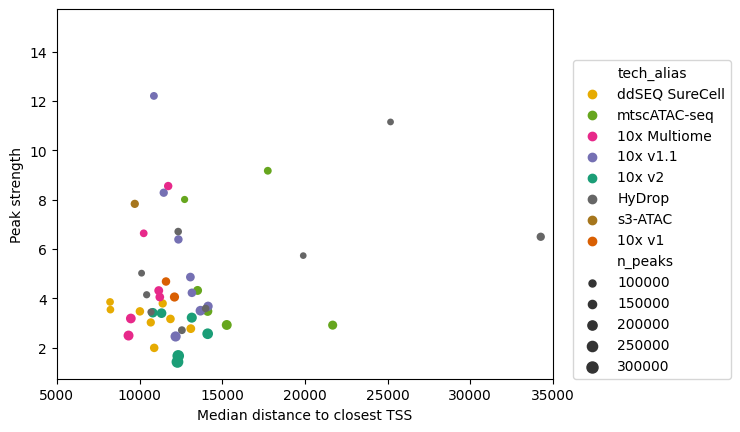

In [6]:
sns.scatterplot(
    df_medians,
    x="median_peak_tss_dist",
    y="median_peak_score",
    hue="tech_alias",
    palette=tech_alias_color_palette,
    linewidth=0,
    size="n_peaks",
)
plt.xlim([5000, 35000])

plt.legend(loc=(1.04, 0))
plt.xlabel("Median distance to closest TSS")
plt.ylabel("Peak strength")
plt.savefig("plts_final/peak_distance_TSS.png", facecolor="white", dpi=300)
plt.savefig("plts_final/peak_distance_TSS.svg", facecolor="white", dpi=300)

# plt.xscale("log")

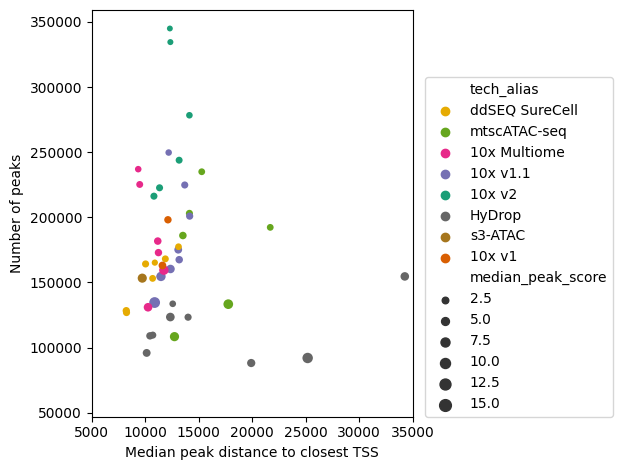

In [7]:
sns.scatterplot(
    df_medians,
    x="median_peak_tss_dist",
    y="n_peaks",
    hue="tech_alias",
    palette=tech_alias_color_palette,
    linewidth=0,
    size="median_peak_score",
)
plt.xlim([5000, 35000])
plt.legend(loc=(1.04, 0))
plt.xlabel("Median peak distance to closest TSS")
plt.ylabel("Number of peaks")
plt.tight_layout()

plt.savefig("plts_final/peak_distance_TSS.png", facecolor="white", dpi=300)
plt.savefig("plts_final/peak_distance_TSS.svg", facecolor="white", dpi=300)
# plt.xscale("log")

In [8]:
np.log(df_merged.sort_values("tss_dist")["tss_dist"])

np.log(df_merged.sort_values("tss_dist")["tss_dist"] + 2)

df_hist = pd.DataFrame(
    np.histogram(np.log(df_merged.sort_values("tss_dist")["tss_dist"] + 2), bins=100)
).T

np.log(df_merged.sort_values("tss_dist")["tss_dist"] + 2)

pd.DataFrame(np.log(df_merged.sort_values("tss_dist")["tss_dist"].dropna())).dropna()

np.log10(df_merged[df_merged["tss_dist"] >= 0]["tss_dist"] + 1)

/opt/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0          5.027460
1          4.984541
2          4.898681
3          4.761958
4          4.732635
             ...   
8115930    5.526940
8115931    5.518823
8115932    5.503033
8115933    5.432746
8115934    5.418187
Name: tss_dist, Length: 8107598, dtype: float64

In [9]:
# sns.histplot(
#     data=np.log10(df_merged[df_merged["tss_dist"] >= 0]["tss_dist"] + 1),
# )

# plt.xlabel("Log10 distance to nearest TSS (bp)")
# plt.title("Histogram of peak distance to nearest TSS ")
# plt.savefig("test.png", dpi=300, facecolor="white")

# check dars

In [79]:
bed_path_dict = {
    x.split("/")[-1].split("__DARs")[0]: x
    for x in sorted(glob.glob("downstream_analysis/DARs/*/*summits.nearesttssdist.bed"))
}

In [88]:
col_names = [
    "chrom",
    "start",
    "end",
    "name",
    "score",
    "strand",
    "pval",
    "tss_chrom",
    "tss_start",
    "tss_end",
    "tss_name",
    "tss_score",
    "tss_strand",
    "tss_dist",
    "sample_id",
    "tech",
]

df_merged = pd.DataFrame()
if not os.path.exists("df_merged_dars.tsv"):
    for sample, path in bed_path_dict.items():
        print(sample)

        df = pd.read_csv(
            path,
            sep="\t",
            header=None,
            names=col_names,
        )
        df["sample_id"] = sample
        df["tech"] = sample.split("_")[1]

        df_merged = pd.concat([df_merged, df])
        print(len(df))

    df_merged.columns = col_names
    df_merged.to_csv("df_merged_dars.tsv", header=True, index=False, sep="\t")
else:
    df_merged = pd.read_csv("df_merged_dars.tsv", header=0, sep="\t")
    df_merged.columns = col_names

df_merged["cell_type"] = [x.split("__")[-1] for x in df_merged["sample_id"]]
df_merged["tech"] = [x.split("_")[1] for x in df_merged["sample_id"]]

df_medians = df_merged.groupby(["sample_id", "cell_type"]).median()
df_medians = df_medians[["score", "tss_dist"]]

df_medians["tech"] = [x.split("_")[1] for x in df_medians.index.get_level_values(0)]

df_merged["true_sample_id"] = [x.split("__")[0] for x in df_merged["sample_id"]]

df_medians = df_merged.groupby(["true_sample_id"]).median()
df_medians = df_medians[["score", "tss_dist"]]
df_medians["tech"] = [x.split("_")[1] for x in df_medians.index.get_level_values(0)]

/tmp/ipykernel_1413185/3711133461.py:40: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv("df_merged_dars.tsv", header=0, sep="\t")
/tmp/ipykernel_1413185/3711133461.py:46: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_medians = df_merged.groupby(["sample_id", "cell_type"]).median()
/tmp/ipykernel_1413185/3711133461.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medians["tech"] = [x.split("_")[1] for x in df_medians.index.get_level_values(0)]
/tmp/ipykernel_141318

In [89]:
df_merged["cell_type"] = [x.split("__")[-1] for x in df_merged["sample_id"]]
df_merged["tech"] = [x.split("_")[1] for x in df_merged["sample_id"]]
df_merged["true_sample_id"] = [x.split("__")[0] for x in df_merged["sample_id"]]

In [90]:
df_medians = df_merged.groupby(["sample_id", "cell_type"]).median()
df_medians = df_medians[["score", "tss_dist"]]
df_medians["tech"] = [x.split("_")[1] for x in df_medians.index.get_level_values(0)]

df_medians["tech_alias"] = [tech_alias_dict[x] for x in df_medians["tech"]]

/tmp/ipykernel_1413185/788030627.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_medians = df_merged.groupby(["sample_id", "cell_type"]).median()
/tmp/ipykernel_1413185/788030627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medians["tech"] = [x.split("_")[1] for x in df_medians.index.get_level_values(0)]
/tmp/ipykernel_1413185/788030627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [91]:
df_medians

,,score,tss_dist,tech,tech_alias
sample_id,cell_type,,,,
BIO_ddseq_1.FIXEDCELLS__B_cell,B_cell,1.719238,7023.0,ddseq,ddSEQ SureCell
BIO_ddseq_1.FIXEDCELLS__CD14+_monocyte,CD14+_monocyte,2.570827,8217.0,ddseq,ddSEQ SureCell
BIO_ddseq_1.FIXEDCELLS__CD4+_T_cell,CD4+_T_cell,1.254371,8699.0,ddseq,ddSEQ SureCell
BIO_ddseq_1.FIXEDCELLS__Cytotoxic_T_cell,Cytotoxic_T_cell,0.954103,11862.5,ddseq,ddSEQ SureCell
BIO_ddseq_1.FIXEDCELLS__Dendritic_cell,Dendritic_cell,1.791816,8265.0,ddseq,ddSEQ SureCell
...,...,...,...,...,...
VIB_hydrop_1.FIXEDCELLS__Cytotoxic_T_cell,Cytotoxic_T_cell,1.191512,8043.0,hydrop,HyDrop
VIB_hydrop_2.FIXEDCELLS__B_cell,B_cell,1.811585,8729.5,hydrop,HyDrop
VIB_hydrop_2.FIXEDCELLS__CD14+_monocyte,CD14+_monocyte,2.853529,16344.5,hydrop,HyDrop


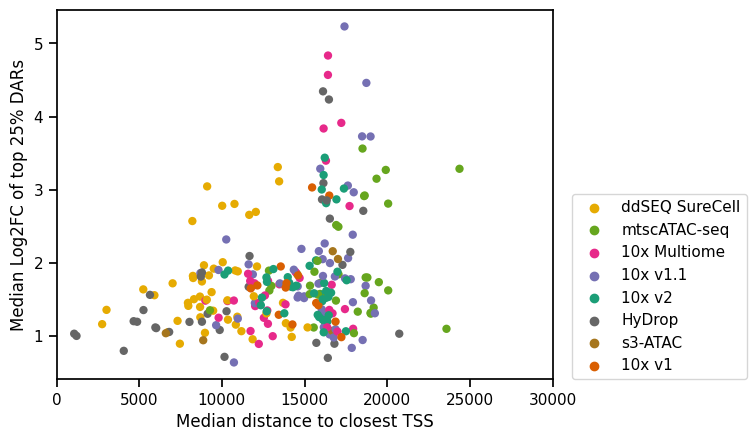

In [92]:
sns.scatterplot(
    df_medians,
    x="tss_dist",
    y="score",
    hue="tech_alias",
    palette=tech_alias_color_palette,
    linewidth=0,
)
plt.xlim([0, 30000])
plt.legend(loc=(1.04, 0))
plt.xlabel("Median distance to closest TSS")
plt.ylabel("Median Log2FC of top 25% DARs")
plt.savefig("plts_final/DAR_distance_TSS.png", facecolor="white", dpi=300)
plt.savefig("plts_final/DAR_distance_TSS.svg", facecolor="white", dpi=300)

# plt.xscale("log")

In [93]:
df_merged["true_sample_id"] = [x.split("__")[0] for x in df_merged["sample_id"]]

df_medians = df_merged.groupby(["true_sample_id"]).median()
df_medians = df_medians[["score", "tss_dist"]]
df_medians["tech"] = [x.split("_")[1] for x in df_medians.index.get_level_values(0)]

df_medians["n_dars"] = df_merged["true_sample_id"].value_counts()
df_medians["tech_alias"] = [tech_alias_dict[x] for x in df_medians["tech"]]

/tmp/ipykernel_1413185/2549300701.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_medians = df_merged.groupby(["true_sample_id"]).median()
/tmp/ipykernel_1413185/2549300701.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medians["tech"] = [x.split("_")[1] for x in df_medians.index.get_level_values(0)]
/tmp/ipykernel_1413185/2549300701.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [94]:
df_medians.to_csv("median_dar_tss_dist.tsv", sep="\t", header=True, index=True)

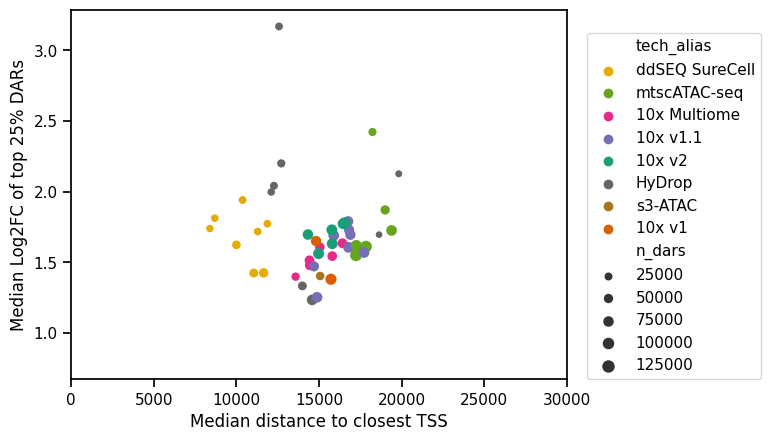

In [95]:
sns.scatterplot(
    df_medians,
    x="tss_dist",
    y="score",
    hue="tech_alias",
    palette=tech_alias_color_palette,
    linewidth=0,
    size="n_dars",
)
plt.xlim([0, 30000])
plt.legend(loc=(1.04, 0))
plt.xlabel("Median distance to closest TSS")
plt.ylabel("Median Log2FC of top 25% DARs")
plt.savefig("plts_final/DAR_distance_TSS.png", facecolor="white", dpi=300)
plt.savefig("plts_final/DAR_distance_TSS.svg", facecolor="white", dpi=300)

# plt.xscale("log")

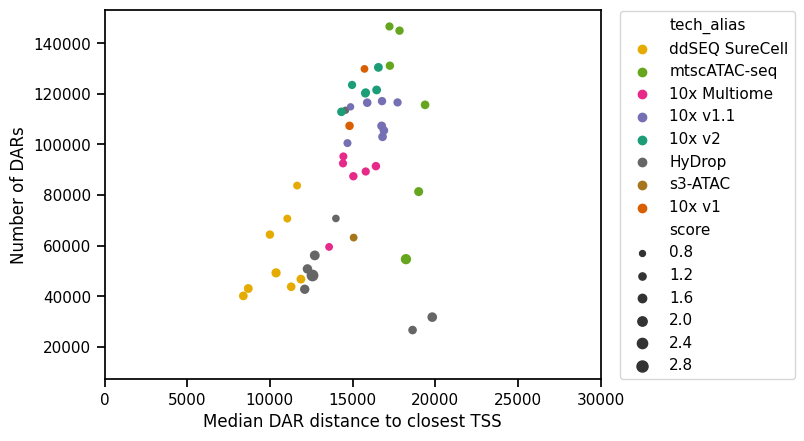

In [96]:
sns.scatterplot(
    df_medians,
    x="tss_dist",
    y="n_dars",
    hue="tech_alias",
    palette=tech_alias_color_palette,
    linewidth=0,
    size="score",
)
plt.xlim([0, 30000])
plt.legend(loc=(1.04, 0))
plt.xlabel("Median DAR distance to closest TSS")
plt.ylabel("Number of DARs")

plt.savefig("plts_final/DAR_distance_TSS.png", facecolor="white", dpi=300)
plt.savefig("plts_final/DAR_distance_TSS.svg", facecolor="white", dpi=300)

# plt.xscale("log")

# Check only top DARs

In [84]:
n_dars = 2000
df_merged_top = pd.DataFrame()
for sample in df_merged["sample_id"].unique():
    print(sample)
    df_merged_sub = df_merged[df_merged["sample_id"] == sample]
    df_merged_sub = df_merged_sub.sort_values(
        by=["score"], ascending=False
    ).reset_index(drop=False)[:n_dars]
    df_merged_top = pd.concat([df_merged_top, df_merged_sub])

BIO_ddseq_1.FIXEDCELLS__B_cell
BIO_ddseq_1.FIXEDCELLS__CD14+_monocyte
BIO_ddseq_1.FIXEDCELLS__CD4+_T_cell
BIO_ddseq_1.FIXEDCELLS__Cytotoxic_T_cell
BIO_ddseq_1.FIXEDCELLS__Dendritic_cell
BIO_ddseq_1.FIXEDCELLS__Natural_killer_cell
BIO_ddseq_2.FIXEDCELLS__B_cell
BIO_ddseq_2.FIXEDCELLS__CD14+_monocyte
BIO_ddseq_2.FIXEDCELLS__CD4+_T_cell
BIO_ddseq_2.FIXEDCELLS__Cytotoxic_T_cell
BIO_ddseq_2.FIXEDCELLS__Dendritic_cell
BIO_ddseq_2.FIXEDCELLS__Natural_killer_cell
BIO_ddseq_3.FIXEDCELLS__B_cell
BIO_ddseq_3.FIXEDCELLS__CD14+_monocyte
BIO_ddseq_3.FIXEDCELLS__CD16+_monocyte
BIO_ddseq_3.FIXEDCELLS__CD4+_T_cell
BIO_ddseq_3.FIXEDCELLS__Cytotoxic_T_cell
BIO_ddseq_3.FIXEDCELLS__Dendritic_cell
BIO_ddseq_3.FIXEDCELLS__Natural_killer_cell
BIO_ddseq_4.FIXEDCELLS__B_cell
BIO_ddseq_4.FIXEDCELLS__CD14+_monocyte
BIO_ddseq_4.FIXEDCELLS__CD16+_monocyte
BIO_ddseq_4.FIXEDCELLS__CD4+_T_cell
BIO_ddseq_4.FIXEDCELLS__Cytotoxic_T_cell
BIO_ddseq_4.FIXEDCELLS__Dendritic_cell
BIO_ddseq_4.FIXEDCELLS__Natural_killer_cell
BR

In [85]:
df_merged_top["cell_type"] = [x.split("__")[-1] for x in df_merged_top["sample_id"]]
df_merged_top["tech"] = [x.split("_")[1] for x in df_merged_top["sample_id"]]

df_medians = df_merged_top.groupby(["sample_id", "cell_type"]).median()
df_medians = df_medians[["score", "tss_dist"]]

df_medians["tech"] = [x.split("_")[1] for x in df_medians.index.get_level_values(0)]

/tmp/ipykernel_1413185/196563981.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_medians = df_merged_top.groupby(["sample_id", "cell_type"]).median()
/tmp/ipykernel_1413185/196563981.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medians["tech"] = [x.split("_")[1] for x in df_medians.index.get_level_values(0)]


In [86]:
df_merged_top["true_sample_id"] = [x.split("__")[0] for x in df_merged_top["sample_id"]]

df_medians = df_merged_top.groupby(["true_sample_id"]).median()
df_medians = df_medians[["score", "tss_dist"]]
df_medians["tech"] = [x.split("_")[1] for x in df_medians.index.get_level_values(0)]

df_medians["n_dars"] = df_merged["true_sample_id"].value_counts()
df_medians["tech_alias"] = [tech_alias_dict[x] for x in df_medians["tech"]]

/tmp/ipykernel_1413185/2143544961.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_medians = df_merged_top.groupby(["true_sample_id"]).median()
/tmp/ipykernel_1413185/2143544961.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medians["tech"] = [x.split("_")[1] for x in df_medians.index.get_level_values(0)]
/tmp/ipykernel_1413185/2143544961.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [87]:
df_medians.to_csv("median_top2kdar_tss_dist.tsv", sep="\t", header=True, index=True)

In [54]:
df_medians.columns = ["DAR Log2(FC)", "tss_dist", "tech", "Number of DARs", "Technique"]

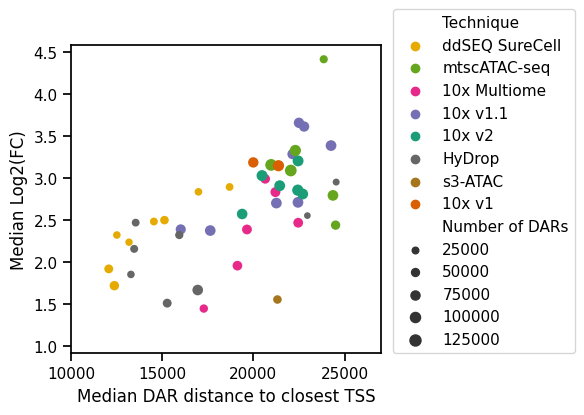

In [67]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    df_medians,
    x="tss_dist",
    y="DAR Log2(FC)",
    hue="Technique",
    palette=tech_alias_color_palette,
    linewidth=0,
    size="Number of DARs",
    ax=ax,
)
plt.xlim([10000, 27000])
plt.legend(loc=(1.04, 0))
plt.xlabel("Median DAR distance to closest TSS")
plt.ylabel("Median Log2(FC)")
plt.savefig("plts_final/DAR_distance_TSS_log2fc.png", facecolor="white", dpi=300)
plt.savefig("plts_final/DAR_distance_TSS_log2fc.svg", facecolor="white", dpi=300)

# plt.xscale("log")

In [69]:
df_medians["Fold-change enrichment"] = 2 ** df_medians["DAR Log2(FC)"]

/tmp/ipykernel_1413185/2376350970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_medians["Fold-change enrichment"] = 2**df_medians["DAR Log2(FC)"]


In [71]:
df_medians

,DAR Log2(FC),tss_dist,tech,Number of DARs,Technique,Fold-change enrichment
true_sample_id,,,,,,
BIO_ddseq_1.FIXEDCELLS,2.236555,13182.0,ddseq,40140,ddSEQ SureCell,4.712703
BIO_ddseq_2.FIXEDCELLS,2.322224,12514.0,ddseq,43064,ddSEQ SureCell,5.001026
BIO_ddseq_3.FIXEDCELLS,1.718140,12377.5,ddseq,83743,ddSEQ SureCell,3.290120
BIO_ddseq_4.FIXEDCELLS,1.918273,12071.0,ddseq,70692,ddSEQ SureCell,3.779703
BRO_mtscatac_1.FIXEDCELLS,3.158546,20975.5,mtscatac,146624,mtscATAC-seq,8.929293
BRO_mtscatac_2.FIXEDCELLS,3.091603,22052.5,mtscatac,144961,mtscATAC-seq,8.524430
CNA_10xmultiome_1.FIXEDCELLS,2.468669,22459.5,10xmultiome,91417,10x Multiome,5.535328
CNA_10xmultiome_2.FIXEDCELLS,1.956868,19126.0,10xmultiome,89307,10x Multiome,3.882183
CNA_10xv11_1.FIXEDCELLS,3.660620,22501.0,10xv11,107309,10x v1.1,12.646095


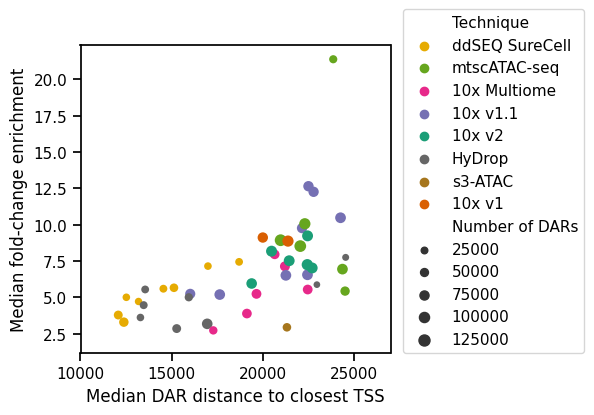

In [70]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    df_medians,
    x="tss_dist",
    y="Fold-change enrichment",
    hue="Technique",
    palette=tech_alias_color_palette,
    linewidth=0,
    size="Number of DARs",
    ax=ax,
)
plt.xlim([10000, 27000])
plt.legend(loc=(1.04, 0))
plt.xlabel("Median DAR distance to closest TSS")
plt.ylabel("Median fold-change enrichment")
plt.savefig("plts_final/DAR_distance_TSS_fc.png", facecolor="white", dpi=300)
plt.savefig("plts_final/DAR_distance_TSS_fc.svg", facecolor="white", dpi=300)

# plt.xscale("log")

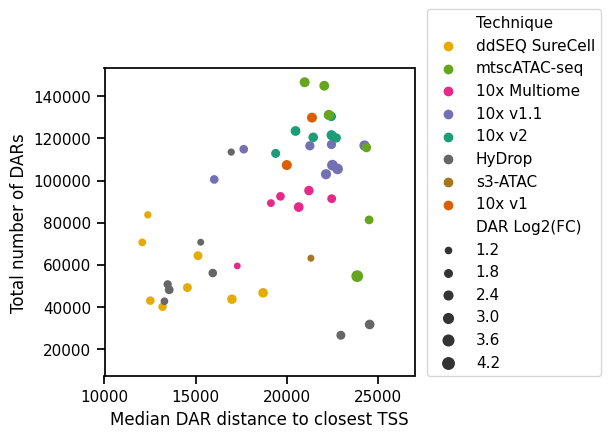

In [63]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    df_medians,
    x="tss_dist",
    y="Number of DARs",
    hue="Technique",
    palette=tech_alias_color_palette,
    linewidth=0,
    size="DAR Log2(FC)",
    ax=ax,
)
plt.xlim([10000, 27000])
plt.legend(loc=(1.04, 0))
plt.xlabel("Median DAR distance to closest TSS")
plt.ylabel("Total number of DARs")
plt.savefig("plts_final/DAR_distance_TSS_ndars.png", facecolor="white", dpi=300)
plt.savefig("plts_final/DAR_distance_TSS_ndars.svg", facecolor="white", dpi=300)

# plt.xscale("log")

# scatterplots for DARs

In [50]:
col_names = "chrom start end name score strand p_val tss_chrom tss_start tss_end tss_name tss_score tss_strand tss_dist".split()


df_merged = pd.DataFrame()
for sample, path in bed_path_dict.items():
    print(sample)

    df = pd.read_csv(
        path,
        sep="\t",
        header=None,
        names=col_names,
    )
    df["sample_id"] = sample
    df["tech"] = sample.split("_")[1]
    df["cell_type"] = sample.split("__")[-1]
    df_sub = df[df["score"] >= np.percentile(df["score"], 75)].sort_values(
        "score", ascending=False
    )
    df_merged = pd.concat([df_merged, df_sub])

df_merged["cell_type"] = [x.split("__")[-1] for x in df_merged["sample_id"]]
df_merged["tech"] = [x.split("_")[1] for x in df_merged["sample_id"]]
df_merged["true_sample_id"] = [x.split("__")[0] for x in df_merged["sample_id"]]
df_merged["tech_alias"] = [tech_alias_dict[x] for x in df_merged["tech"]]

BIO_ddseq_1.FIXEDCELLS__B_cell
BIO_ddseq_1.FIXEDCELLS__CD14+_monocyte
BIO_ddseq_1.FIXEDCELLS__CD4+_T_cell
BIO_ddseq_1.FIXEDCELLS__Cytotoxic_T_cell
BIO_ddseq_1.FIXEDCELLS__Dendritic_cell
BIO_ddseq_1.FIXEDCELLS__Natural_killer_cell
BIO_ddseq_2.FIXEDCELLS__B_cell
BIO_ddseq_2.FIXEDCELLS__CD14+_monocyte
BIO_ddseq_2.FIXEDCELLS__CD4+_T_cell
BIO_ddseq_2.FIXEDCELLS__Cytotoxic_T_cell
BIO_ddseq_2.FIXEDCELLS__Dendritic_cell
BIO_ddseq_2.FIXEDCELLS__Natural_killer_cell
BIO_ddseq_3.FIXEDCELLS__B_cell
BIO_ddseq_3.FIXEDCELLS__CD14+_monocyte
BIO_ddseq_3.FIXEDCELLS__CD16+_monocyte
BIO_ddseq_3.FIXEDCELLS__CD4+_T_cell
BIO_ddseq_3.FIXEDCELLS__Cytotoxic_T_cell
BIO_ddseq_3.FIXEDCELLS__Dendritic_cell
BIO_ddseq_3.FIXEDCELLS__Natural_killer_cell
BIO_ddseq_4.FIXEDCELLS__B_cell
BIO_ddseq_4.FIXEDCELLS__CD14+_monocyte
BIO_ddseq_4.FIXEDCELLS__CD16+_monocyte
BIO_ddseq_4.FIXEDCELLS__CD4+_T_cell
BIO_ddseq_4.FIXEDCELLS__Cytotoxic_T_cell
BIO_ddseq_4.FIXEDCELLS__Dendritic_cell
BIO_ddseq_4.FIXEDCELLS__Natural_killer_cell
BR

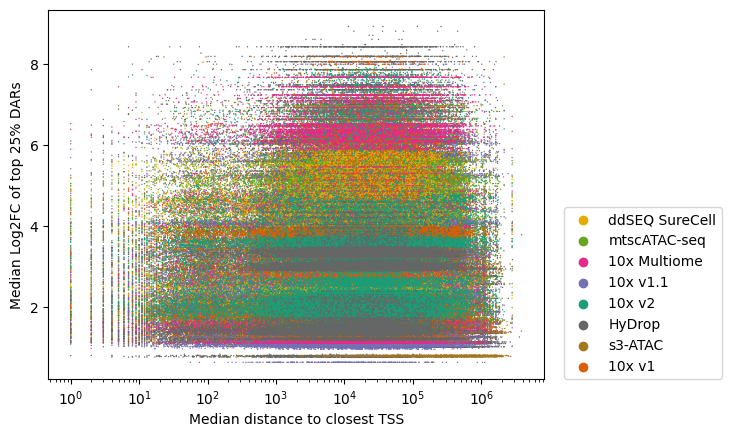

In [52]:
sns.scatterplot(
    df_merged,
    x="tss_dist",
    y="score",
    hue="tech_alias",
    palette=tech_alias_color_palette,
    linewidth=0,
    s=1,
)
# plt.xlim([0, 50000])
plt.legend(loc=(1.04, 0))
plt.xlabel("Median distance to closest TSS")
plt.ylabel("Median Log2FC of top 25% DARs")
# plt.savefig("plts_final/DAR_distance_TSS.png", facecolor="white", dpi=300)
# plt.savefig("plts_final/DAR_distance_TSS.svg", facecolor="white", dpi=300)

plt.xscale("log")

In [53]:
df_merged

,chrom,start,end,name,score,strand,p_val,tss_chrom,tss_start,tss_end,tss_name,tss_score,tss_strand,tss_dist,sample_id,tech,cell_type,true_sample_id,tech_alias
2877,chr2,88845973,88845974,B_cell_0,4.347702,.,1.239461e-228,chr2,88691673,88691674,RPIA,NaN,1,154300,BIO_ddseq_1.FIXEDCELLS__B_cell,ddseq,B_cell,BIO_ddseq_1.FIXEDCELLS,ddSEQ SureCell
4605,chr7,74101270,74101271,B_cell_3,4.347702,.,1.239461e-228,chr7,74093079,74093080,LIMK1,NaN,1,8191,BIO_ddseq_1.FIXEDCELLS__B_cell,ddseq,B_cell,BIO_ddseq_1.FIXEDCELLS,ddSEQ SureCell
2378,chr18,76965847,76965848,B_cell_10,4.347702,.,1.239461e-228,chr18,76990023,76990024,MBP,NaN,-1,24176,BIO_ddseq_1.FIXEDCELLS__B_cell,ddseq,B_cell,BIO_ddseq_1.FIXEDCELLS,ddSEQ SureCell
3476,chr3,13022735,13022736,B_cell_1,4.347702,.,1.239461e-228,chr3,13022596,13022597,IQSEC1,NaN,-1,139,BIO_ddseq_1.FIXEDCELLS__B_cell,ddseq,B_cell,BIO_ddseq_1.FIXEDCELLS,ddSEQ SureCell
1156,chr12,92703038,92703039,B_cell_7,4.347702,.,1.239461e-228,chr12,92703028,92703029,PLEKHG7,NaN,1,10,BIO_ddseq_1.FIXEDCELLS__B_cell,ddseq,B_cell,BIO_ddseq_1.FIXEDCELLS,ddSEQ SureCell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,chr12,10672689,10672690,Cytotoxic_T_cell_1937,1.405742,.,1.368339e-143,chr12,10673658,10673659,STYK1,NaN,-1,969,VIB_hydrop_2.FIXEDCELLS__Cytotoxic_T_cell,hydrop,Cytotoxic_T_cell,VIB_hydrop_2.FIXEDCELLS,HyDrop
1452,chr11,67024681,67024682,Cytotoxic_T_cell_1927,1.405742,.,1.368339e-143,chr11,67023134,67023135,SYT12,NaN,1,1547,VIB_hydrop_2.FIXEDCELLS__Cytotoxic_T_cell,hydrop,Cytotoxic_T_cell,VIB_hydrop_2.FIXEDCELLS,HyDrop
7544,chr9,89477585,89477586,Cytotoxic_T_cell_1953,1.405742,.,1.368339e-143,chr9,89479890,89479891,SEMA4D,NaN,-1,2305,VIB_hydrop_2.FIXEDCELLS__Cytotoxic_T_cell,hydrop,Cytotoxic_T_cell,VIB_hydrop_2.FIXEDCELLS,HyDrop
5504,chr3,102114422,102114423,Cytotoxic_T_cell_1963,1.405742,.,1.368339e-143,chr3,102099244,102099245,ZPLD1,NaN,1,15178,VIB_hydrop_2.FIXEDCELLS__Cytotoxic_T_cell,hydrop,Cytotoxic_T_cell,VIB_hydrop_2.FIXEDCELLS,HyDrop


StopIteration: 

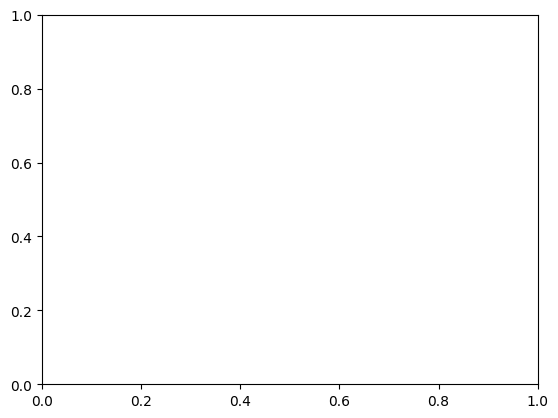

In [54]:
sns.histplot(
    data=np.log(df_merged.sort_values("tss_dist")["tss_dist"] + 2),
)
plt.xlim([1, 15])
plt.ylim([0, 60000])
plt.xlabel("Log10 distance to nearest TSS (bp)")
plt.title("Histogram of distance to nearest TSS of non-TSS peaks")

In [ ]:
sns.histplot(
    data=np.log10(df_merged[df_merged["tss_dist"] >= 0]["tss_dist"] + 1),
)
# plt.xlim([-1, 15])
plt.ylim([0, 35000])
plt.xlabel("Log10 distance to nearest TSS (bp)")
plt.title("Histogram of distance to nearest TSS")

In [ ]:
np.log10(df_merged[df_merged["tss_dist"] >= 0]["tss_dist"] + 1)